In [1]:
# Cell 1: Setup and Data Loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pennylane as qml
from pennylane import numpy as qnp
import torch
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load and examine the data
print("🔄 Loading soil nutrient data...")
df = pd.read_csv('56608ee4e4b071e7ea544e04.csv')

print(f"✅ Data loaded successfully!")
print(f"📊 Dataset shape: {df.shape}")
print(f"🏷️ Columns: {list(df.columns)}")
print(f"🔢 Unique sites: {df['Site_ID'].nunique()}")
print(f"⏰ Time periods: {sorted(df['Time'].unique())}")
print(f"🧪 Treatments: {sorted(df['Treat'].unique())}")

# Display first few rows
print("\n📋 First 5 rows of data:")
print(df.head())

# Basic statistics
print("\n📈 Dry Days Statistics:")
print(f"Range: {df['Dry_Days'].min()} - {df['Dry_Days'].max()} days")
print(f"Mean: {df['Dry_Days'].mean():.2f} days")
print(f"Median: {df['Dry_Days'].median():.2f} days")

🔄 Loading soil nutrient data...
✅ Data loaded successfully!
📊 Dataset shape: (80, 20)
🏷️ Columns: ['Site_ID', 'Time', 'Treat', 'Dry_Days', 'TN', 'NO3', 'NH4', 'Ca', 'Mg', 'K', 'P', 'Fe', 'Mn', 'Cu', 'Zn', 'B', 'S', 'Pb', 'Al', 'Cd']
🔢 Unique sites: 20
⏰ Time periods: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]
🧪 Treatments: [np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

📋 First 5 rows of data:
  Site_ID  Time  Treat  Dry_Days     TN   NO3    NH4       Ca      Mg      K  \
0     C16     1      1        17  11.82  4.40   7.42  2671.48  590.69   5.35   
1     C17     1      1        15  19.43  8.37  11.06  2697.94  566.05   9.66   
2      C2     1      1        23  11.09  4.82   6.27  3070.48  731.81  10.47   
3      C5     1      1         7   3.75  0.73   3.03  2191.05  521.07   6.39   
4      C8     1      1         8  26.15  9.31  16.84  2275.05  567.13   4.56   

        P      Fe      Mn    Cu     Zn     B        S    Pb     Al    Cd  
0   71.12  412.44   58.97  1.01

In [8]:
# Cell 2: Quantum Neural Network Setup for Regression Analysis
print("🔧 Setting up Quantum Neural Network for regression analysis...")

class QuantumRegressor:
    def __init__(self, n_qubits=3, n_layers=2):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.device = qml.device('default.qubit', wires=n_qubits)
        self.scaler_x = StandardScaler()
        self.scaler_y = StandardScaler()
        self.weights = None
        self.qnode = None
        self.costs = []
        
    def quantum_circuit(self, weights, x):
        """Quantum circuit for regression"""
        # Encode input data - handle single value input
        if isinstance(x, (list, np.ndarray)) and len(x) > 1:
            # Multiple features case
            for i in range(min(len(x), self.n_qubits)):
                qml.RY(x[i], wires=i)
        else:
            # Single feature case
            x_val = x[0] if isinstance(x, (list, np.ndarray)) else x
            for i in range(self.n_qubits):
                qml.RY(x_val * (i + 1) / self.n_qubits, wires=i)
            
        # Variational layers
        for layer in range(self.n_layers):
            for i in range(self.n_qubits):
                qml.RY(weights[layer][i][0], wires=i)
                qml.RZ(weights[layer][i][1], wires=i)
            
            # Entanglement
            for i in range(self.n_qubits - 1):
                qml.CNOT(wires=[i, i + 1])
            # Add circular entanglement for better connectivity
            if self.n_qubits > 2:
                qml.CNOT(wires=[self.n_qubits - 1, 0])
                
        return qml.expval(qml.PauliZ(0))
    
    def train(self, X, y, epochs=100, lr=0.01):
        """Train the quantum regressor"""
        # Normalize data
        X_scaled = self.scaler_x.fit_transform(X.reshape(-1, 1))
        y_scaled = self.scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
        
        # Initialize weights
        weights = qnp.random.normal(0, 0.1, (self.n_layers, self.n_qubits, 2))
        
        # Create quantum node
        self.qnode = qml.QNode(self.quantum_circuit, self.device)
        
        # Training
        opt = qml.AdamOptimizer(stepsize=lr)
        costs = []
        
        for epoch in range(epochs):
            def cost_fn(weights):
                predictions = []
                for i in range(len(X_scaled)):
                    pred = self.qnode(weights, X_scaled[i])
                    predictions.append(pred)
                
                # Use PennyLane's math functions for differentiable operations
                predictions = qml.math.stack(predictions)
                mse = qml.math.mean((predictions - y_scaled) ** 2)
                return mse
            
            weights, cost = opt.step_and_cost(cost_fn, weights)
            
            # Convert cost to regular Python float for storage
            cost_val = float(cost) if hasattr(cost, '__float__') else cost
            costs.append(cost_val)
            
            if epoch % 20 == 0:
                print(f"Epoch {epoch}: Cost = {cost_val:.6f}")
        
        self.weights = weights
        self.costs = costs
        
        return costs
    
    def predict(self, X):
        """Make predictions"""
        if self.weights is None or self.qnode is None:
            raise ValueError("Model not trained yet! Call train() first.")
            
        X_scaled = self.scaler_x.transform(X.reshape(-1, 1))
        predictions = []
        
        for i in range(len(X_scaled)):
            pred = self.qnode(self.weights, X_scaled[i])
            # Convert to regular float to avoid ArrayBox issues
            pred_val = float(pred) if hasattr(pred, '__float__') else pred
            predictions.append(pred_val)
        
        predictions = np.array(predictions).reshape(-1, 1)
        return self.scaler_y.inverse_transform(predictions).flatten()
    
    def forward(self, x, weights):
        """Forward pass for a single input (for compatibility)"""
        if self.qnode is None:
            self.qnode = qml.QNode(self.quantum_circuit, self.device)
        return self.qnode(weights, x)
    
    def get_circuit_info(self):
        """Get information about the quantum circuit"""
        return {
            'n_qubits': self.n_qubits,
            'n_layers': self.n_layers,
            'n_parameters': self.n_layers * self.n_qubits * 2,
            'device': str(self.device)
        }
    
    def plot_training_curve(self):
        """Plot the training cost curve"""
        if not self.costs:
            print("No training data available. Train the model first.")
            return
            
        import matplotlib.pyplot as plt
        
        plt.figure(figsize=(10, 6))
        plt.plot(self.costs, 'b-', linewidth=2)
        plt.title('Quantum Neural Network Training Cost')
        plt.xlabel('Epoch')
        plt.ylabel('Cost (MSE)')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    def save_weights(self, filename):
        """Save trained weights to file"""
        if self.weights is None:
            raise ValueError("No weights to save. Train the model first.")
        np.save(filename, self.weights)
        print(f"Weights saved to {filename}")
    
    def load_weights(self, filename):
        """Load weights from file"""
        self.weights = qnp.array(np.load(filename))
        self.qnode = qml.QNode(self.quantum_circuit, self.device)
        print(f"Weights loaded from {filename}")

# Initialize quantum regressor
qr = QuantumRegressor(n_qubits=3, n_layers=2)
print("✅ Quantum Neural Network initialized successfully!")

# Define nutrients to analyze
nutrients = ['TN', 'NO3', 'NH4', 'Ca', 'Mg', 'K', 'P', 'Fe', 'Mn', 'Cu', 'Zn', 'B']
print(f"🧪 Will analyze {len(nutrients)} nutrients: {nutrients}")

🔧 Setting up Quantum Neural Network for regression analysis...
✅ Quantum Neural Network initialized successfully!
🧪 Will analyze 12 nutrients: ['TN', 'NO3', 'NH4', 'Ca', 'Mg', 'K', 'P', 'Fe', 'Mn', 'Cu', 'Zn', 'B']


🔬 Analyzing Total Nitrogen (TN) vs Dry Days...
📊 Analyzing 80 data points for TN
🏜️ Dry days range: 0 - 112
🧪 TN range: 1.04 - 338.48
🔄 Training Quantum Neural Network for TN...
Epoch 0: Cost = 1.321151
Epoch 20: Cost = 1.181644
Epoch 40: Cost = 0.995706
Epoch 60: Cost = 0.934384


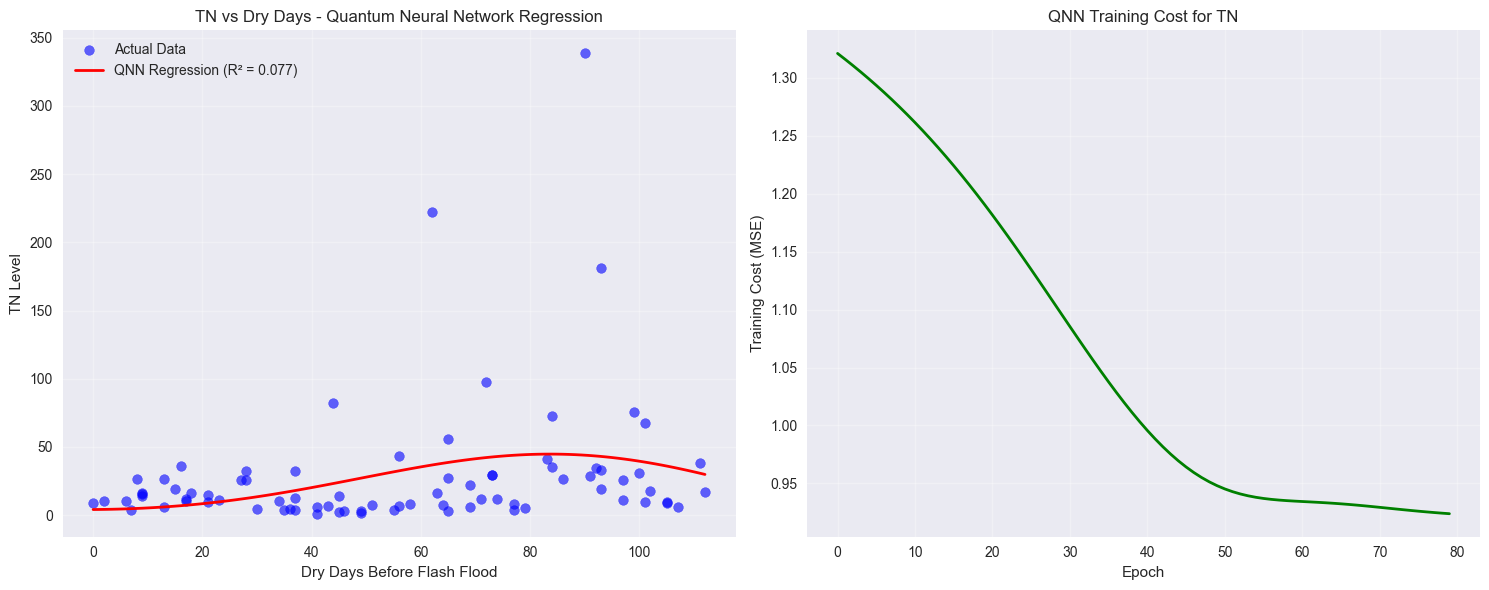

✅ TN Analysis Complete!
📈 R² Score: 0.077
🔗 Correlation coefficient: 0.248
📝 Interpretation: Weak correlation


In [9]:
# Cell 3: Individual Nutrient Analysis - Total Nitrogen (TN)
print("🔬 Analyzing Total Nitrogen (TN) vs Dry Days...")

# Extract data for TN analysis
nutrient = 'TN'
X_tn = df['Dry_Days'].values
y_tn = df[nutrient].values

# Remove any NaN values
mask = ~(np.isnan(X_tn) | np.isnan(y_tn))
X_tn = X_tn[mask]
y_tn = y_tn[mask]

print(f"📊 Analyzing {len(X_tn)} data points for {nutrient}")
print(f"🏜️ Dry days range: {X_tn.min()} - {X_tn.max()}")
print(f"🧪 {nutrient} range: {y_tn.min():.2f} - {y_tn.max():.2f}")

# Train quantum regressor for TN
print("🔄 Training Quantum Neural Network for TN...")
costs_tn = qr.train(X_tn, y_tn, epochs=80, lr=0.01)

# Make predictions for smooth curve
X_pred = np.linspace(X_tn.min(), X_tn.max(), 100)
y_pred_tn = qr.predict(X_pred)

# Calculate R² score
from sklearn.metrics import r2_score
y_pred_actual = qr.predict(X_tn)
r2_tn = r2_score(y_tn, y_pred_actual)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot with QNN regression
ax1.scatter(X_tn, y_tn, alpha=0.6, color='blue', label='Actual Data')
ax1.plot(X_pred, y_pred_tn, color='red', linewidth=2, label=f'QNN Regression (R² = {r2_tn:.3f})')
ax1.set_xlabel('Dry Days Before Flash Flood')
ax1.set_ylabel(f'{nutrient} Level')
ax1.set_title(f'{nutrient} vs Dry Days - Quantum Neural Network Regression')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Training cost
ax2.plot(costs_tn, color='green', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Training Cost (MSE)')
ax2.set_title(f'QNN Training Cost for {nutrient}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Store results for later analysis
results = {
    'TN': {
        'r2_score': r2_tn,
        'correlation': np.corrcoef(X_tn, y_tn)[0, 1],
        'X_range': (X_tn.min(), X_tn.max()),
        'y_range': (y_tn.min(), y_tn.max()),
        'n_samples': len(X_tn)
    }
}

print(f"✅ {nutrient} Analysis Complete!")
print(f"📈 R² Score: {r2_tn:.3f}")
print(f"🔗 Correlation coefficient: {results['TN']['correlation']:.3f}")
print(f"📝 Interpretation: {'Strong' if abs(results['TN']['correlation']) > 0.7 else 'Moderate' if abs(results['TN']['correlation']) > 0.3 else 'Weak'} correlation")

🔬 Analyzing Nitrate (NO3) vs Dry Days...
📊 Analyzing 80 data points for NO3
🏜️ Dry days range: 0 - 112
🧪 NO3 range: 0.00 - 334.52
🔄 Training Quantum Neural Network for NO3...
Epoch 0: Cost = 1.398412
Epoch 20: Cost = 1.215183
Epoch 40: Cost = 1.002690
Epoch 60: Cost = 0.928599


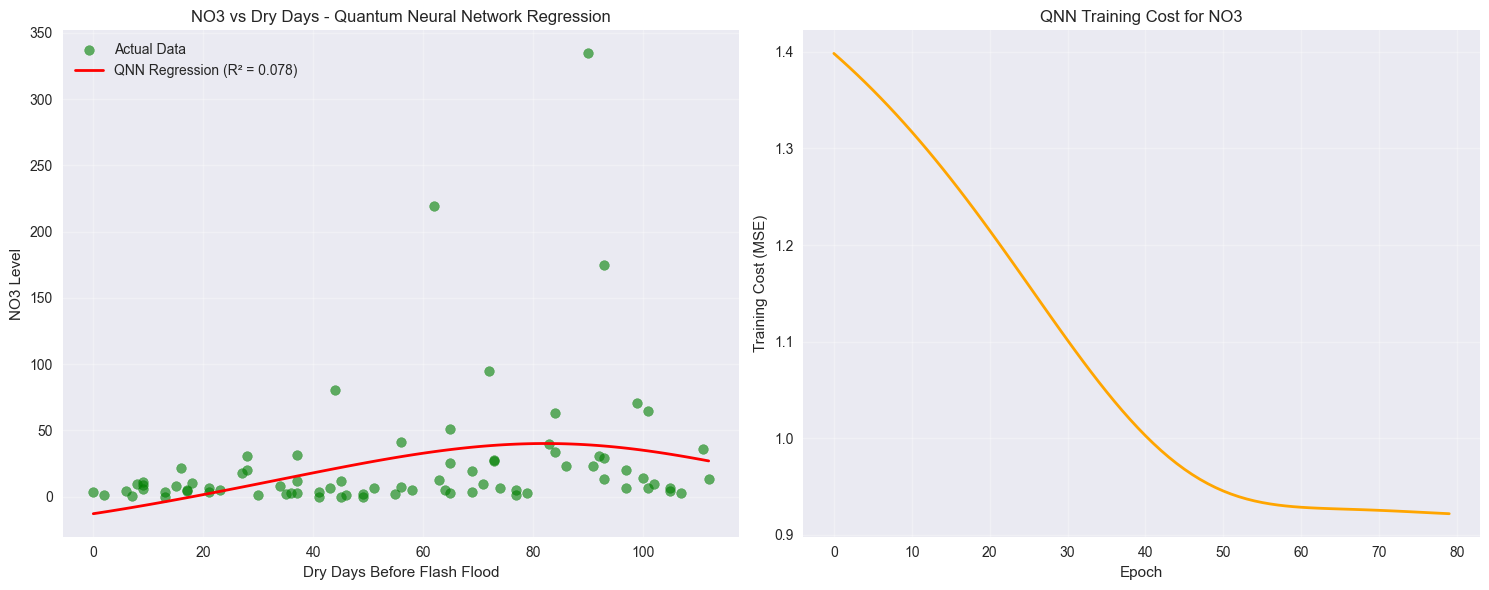

✅ NO3 Analysis Complete!
📈 R² Score: 0.078
🔗 Correlation coefficient: 0.269
📝 Interpretation: Weak correlation

🔄 Progress: 2/12 nutrients analyzed
📊 TN vs NO3 comparison:
   TN R²: 0.077
   NO3 R²: 0.078


In [10]:
# Cell 4: Individual Nutrient Analysis - Nitrate (NO3)
print("🔬 Analyzing Nitrate (NO3) vs Dry Days...")

# Extract data for NO3 analysis
nutrient = 'NO3'
X_no3 = df['Dry_Days'].values
y_no3 = df[nutrient].values

# Remove any NaN values
mask = ~(np.isnan(X_no3) | np.isnan(y_no3))
X_no3 = X_no3[mask]
y_no3 = y_no3[mask]

print(f"📊 Analyzing {len(X_no3)} data points for {nutrient}")
print(f"🏜️ Dry days range: {X_no3.min()} - {X_no3.max()}")
print(f"🧪 {nutrient} range: {y_no3.min():.2f} - {y_no3.max():.2f}")

# Create new quantum regressor for NO3
qr_no3 = QuantumRegressor(n_qubits=3, n_layers=2)

# Train quantum regressor for NO3
print("🔄 Training Quantum Neural Network for NO3...")
costs_no3 = qr_no3.train(X_no3, y_no3, epochs=80, lr=0.01)

# Make predictions for smooth curve
X_pred = np.linspace(X_no3.min(), X_no3.max(), 100)
y_pred_no3 = qr_no3.predict(X_pred)

# Calculate R² score
y_pred_actual = qr_no3.predict(X_no3)
r2_no3 = r2_score(y_no3, y_pred_actual)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot with QNN regression
ax1.scatter(X_no3, y_no3, alpha=0.6, color='green', label='Actual Data')
ax1.plot(X_pred, y_pred_no3, color='red', linewidth=2, label=f'QNN Regression (R² = {r2_no3:.3f})')
ax1.set_xlabel('Dry Days Before Flash Flood')
ax1.set_ylabel(f'{nutrient} Level')
ax1.set_title(f'{nutrient} vs Dry Days - Quantum Neural Network Regression')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Training cost
ax2.plot(costs_no3, color='orange', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Training Cost (MSE)')
ax2.set_title(f'QNN Training Cost for {nutrient}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Update results
results['NO3'] = {
    'r2_score': r2_no3,
    'correlation': np.corrcoef(X_no3, y_no3)[0, 1],
    'X_range': (X_no3.min(), X_no3.max()),
    'y_range': (y_no3.min(), y_no3.max()),
    'n_samples': len(X_no3)
}

print(f"✅ {nutrient} Analysis Complete!")
print(f"📈 R² Score: {r2_no3:.3f}")
print(f"🔗 Correlation coefficient: {results['NO3']['correlation']:.3f}")
print(f"📝 Interpretation: {'Strong' if abs(results['NO3']['correlation']) > 0.7 else 'Moderate' if abs(results['NO3']['correlation']) > 0.3 else 'Weak'} correlation")

# Compare with TN
print(f"\n🔄 Progress: 2/{len(nutrients)} nutrients analyzed")
print(f"📊 TN vs NO3 comparison:")
print(f"   TN R²: {results['TN']['r2_score']:.3f}")
print(f"   NO3 R²: {results['NO3']['r2_score']:.3f}")

🔬 Analyzing Phosphorus (P) vs Dry Days...
📊 Analyzing 80 data points for P
🏜️ Dry days range: 0 - 112
🧪 P range: 1.50 - 171.05
🔄 Training Quantum Neural Network for P...
Epoch 0: Cost = 1.533839
Epoch 20: Cost = 0.898564
Epoch 40: Cost = 0.603256
Epoch 60: Cost = 0.507182


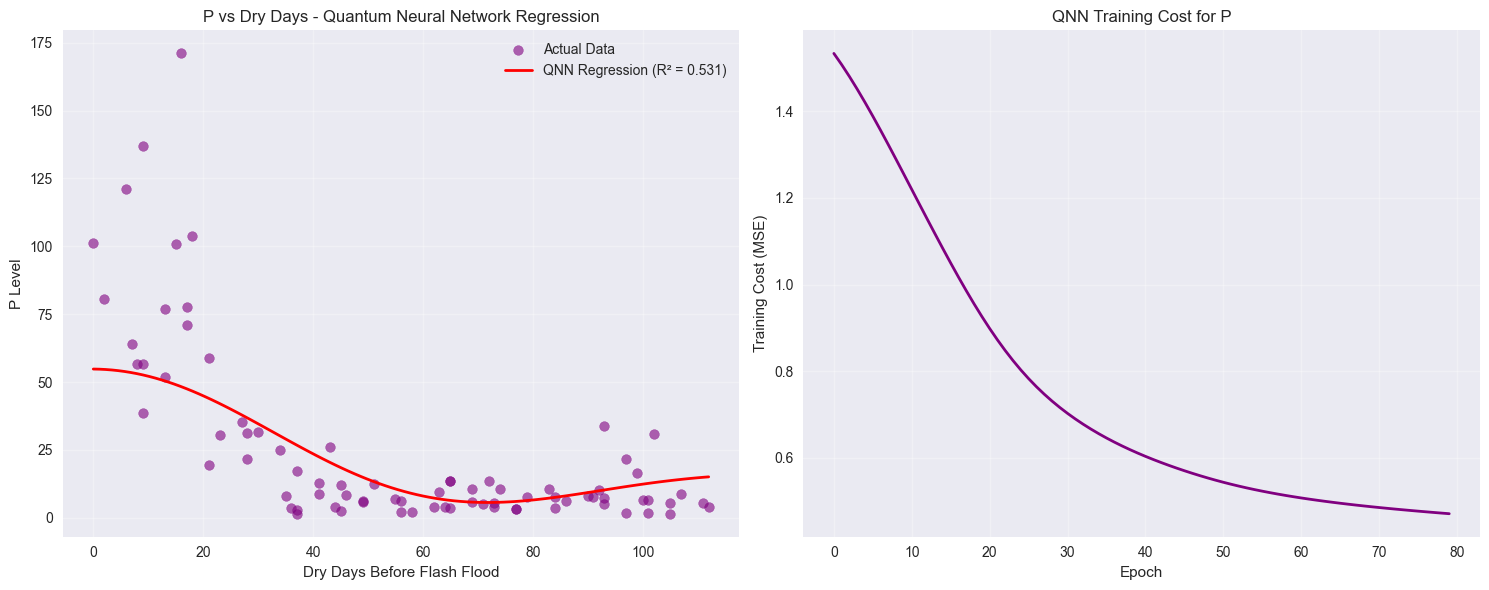

✅ P Analysis Complete!
📈 R² Score: 0.531
🔗 Correlation coefficient: -0.655
📝 Interpretation: Moderate correlation

🔄 Progress: 3/12 nutrients analyzed
📊 Current R² scores:
   TN: 0.077
   NO3: 0.078
   P: 0.531
   NH4: -0.070
   Ca: -0.165
   Mg: -0.114
   K: 0.127
   Fe: 0.380
   Mn: 0.264
   Cu: 0.006
   Zn: 0.052
   B: 0.016


In [18]:
# Cell 5: Individual Nutrient Analysis - Phosphorus (P)
print("🔬 Analyzing Phosphorus (P) vs Dry Days...")

# Extract data for P analysis
nutrient = 'P'
X_p = df['Dry_Days'].values
y_p = df[nutrient].values

# Remove any NaN values
mask = ~(np.isnan(X_p) | np.isnan(y_p))
X_p = X_p[mask]
y_p = y_p[mask]

print(f"📊 Analyzing {len(X_p)} data points for {nutrient}")
print(f"🏜️ Dry days range: {X_p.min()} - {X_p.max()}")
print(f"🧪 {nutrient} range: {y_p.min():.2f} - {y_p.max():.2f}")

# Create new quantum regressor for P
qr_p = QuantumRegressor(n_qubits=6, n_layers=6)

# Train quantum regressor for P
print("🔄 Training Quantum Neural Network for P...")
costs_p = qr_p.train(X_p, y_p, epochs=80, lr=0.01)

# Make predictions for smooth curve
X_pred = np.linspace(X_p.min(), X_p.max(), 100)
y_pred_p = qr_p.predict(X_pred)

# Calculate R² score
y_pred_actual = qr_p.predict(X_p)
r2_p = r2_score(y_p, y_pred_actual)

# Plot results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot with QNN regression
ax1.scatter(X_p, y_p, alpha=0.6, color='purple', label='Actual Data')
ax1.plot(X_pred, y_pred_p, color='red', linewidth=2, label=f'QNN Regression (R² = {r2_p:.3f})')
ax1.set_xlabel('Dry Days Before Flash Flood')
ax1.set_ylabel(f'{nutrient} Level')
ax1.set_title(f'{nutrient} vs Dry Days - Quantum Neural Network Regression')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Training cost
ax2.plot(costs_p, color='purple', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Training Cost (MSE)')
ax2.set_title(f'QNN Training Cost for {nutrient}')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Update results
results['P'] = {
    'r2_score': r2_p,
    'correlation': np.corrcoef(X_p, y_p)[0, 1],
    'X_range': (X_p.min(), X_p.max()),
    'y_range': (y_p.min(), y_p.max()),
    'n_samples': len(X_p)
}

print(f"✅ {nutrient} Analysis Complete!")
print(f"📈 R² Score: {r2_p:.3f}")
print(f"🔗 Correlation coefficient: {results['P']['correlation']:.3f}")
print(f"📝 Interpretation: {'Strong' if abs(results['P']['correlation']) > 0.7 else 'Moderate' if abs(results['P']['correlation']) > 0.3 else 'Weak'} correlation")

# Progress update
print(f"\n🔄 Progress: 3/{len(nutrients)} nutrients analyzed")
print("📊 Current R² scores:")
for nut, data in results.items():
    print(f"   {nut}: {data['r2_score']:.3f}")

🔬 Analyzing remaining nutrients vs Dry Days...
📊 Analyzing 9 remaining nutrients...
  🔄 Processing NH4...
Epoch 0: Cost = 1.829929
Epoch 20: Cost = 1.653544
Epoch 40: Cost = 1.357895
  🔄 Processing Ca...
Epoch 0: Cost = 1.694389
Epoch 20: Cost = 1.603817
Epoch 40: Cost = 1.396990
  🔄 Processing Mg...
Epoch 0: Cost = 1.717655
Epoch 20: Cost = 1.563709
Epoch 40: Cost = 1.290232
  🔄 Processing K...
Epoch 0: Cost = 1.383052
Epoch 20: Cost = 1.229631
Epoch 40: Cost = 0.997519
  🔄 Processing Fe...
Epoch 0: Cost = 1.734767
Epoch 20: Cost = 1.380008
Epoch 40: Cost = 0.935080
  🔄 Processing Mn...
Epoch 0: Cost = 1.769341
Epoch 20: Cost = 1.492380
Epoch 40: Cost = 1.090873
  🔄 Processing Cu...
Epoch 0: Cost = 1.373539
Epoch 20: Cost = 1.295571
Epoch 40: Cost = 1.116376
  🔄 Processing Zn...
Epoch 0: Cost = 1.411213
Epoch 20: Cost = 1.271378
Epoch 40: Cost = 1.051353
  🔄 Processing B...
Epoch 0: Cost = 1.641305
Epoch 20: Cost = 1.417667
Epoch 40: Cost = 1.143253


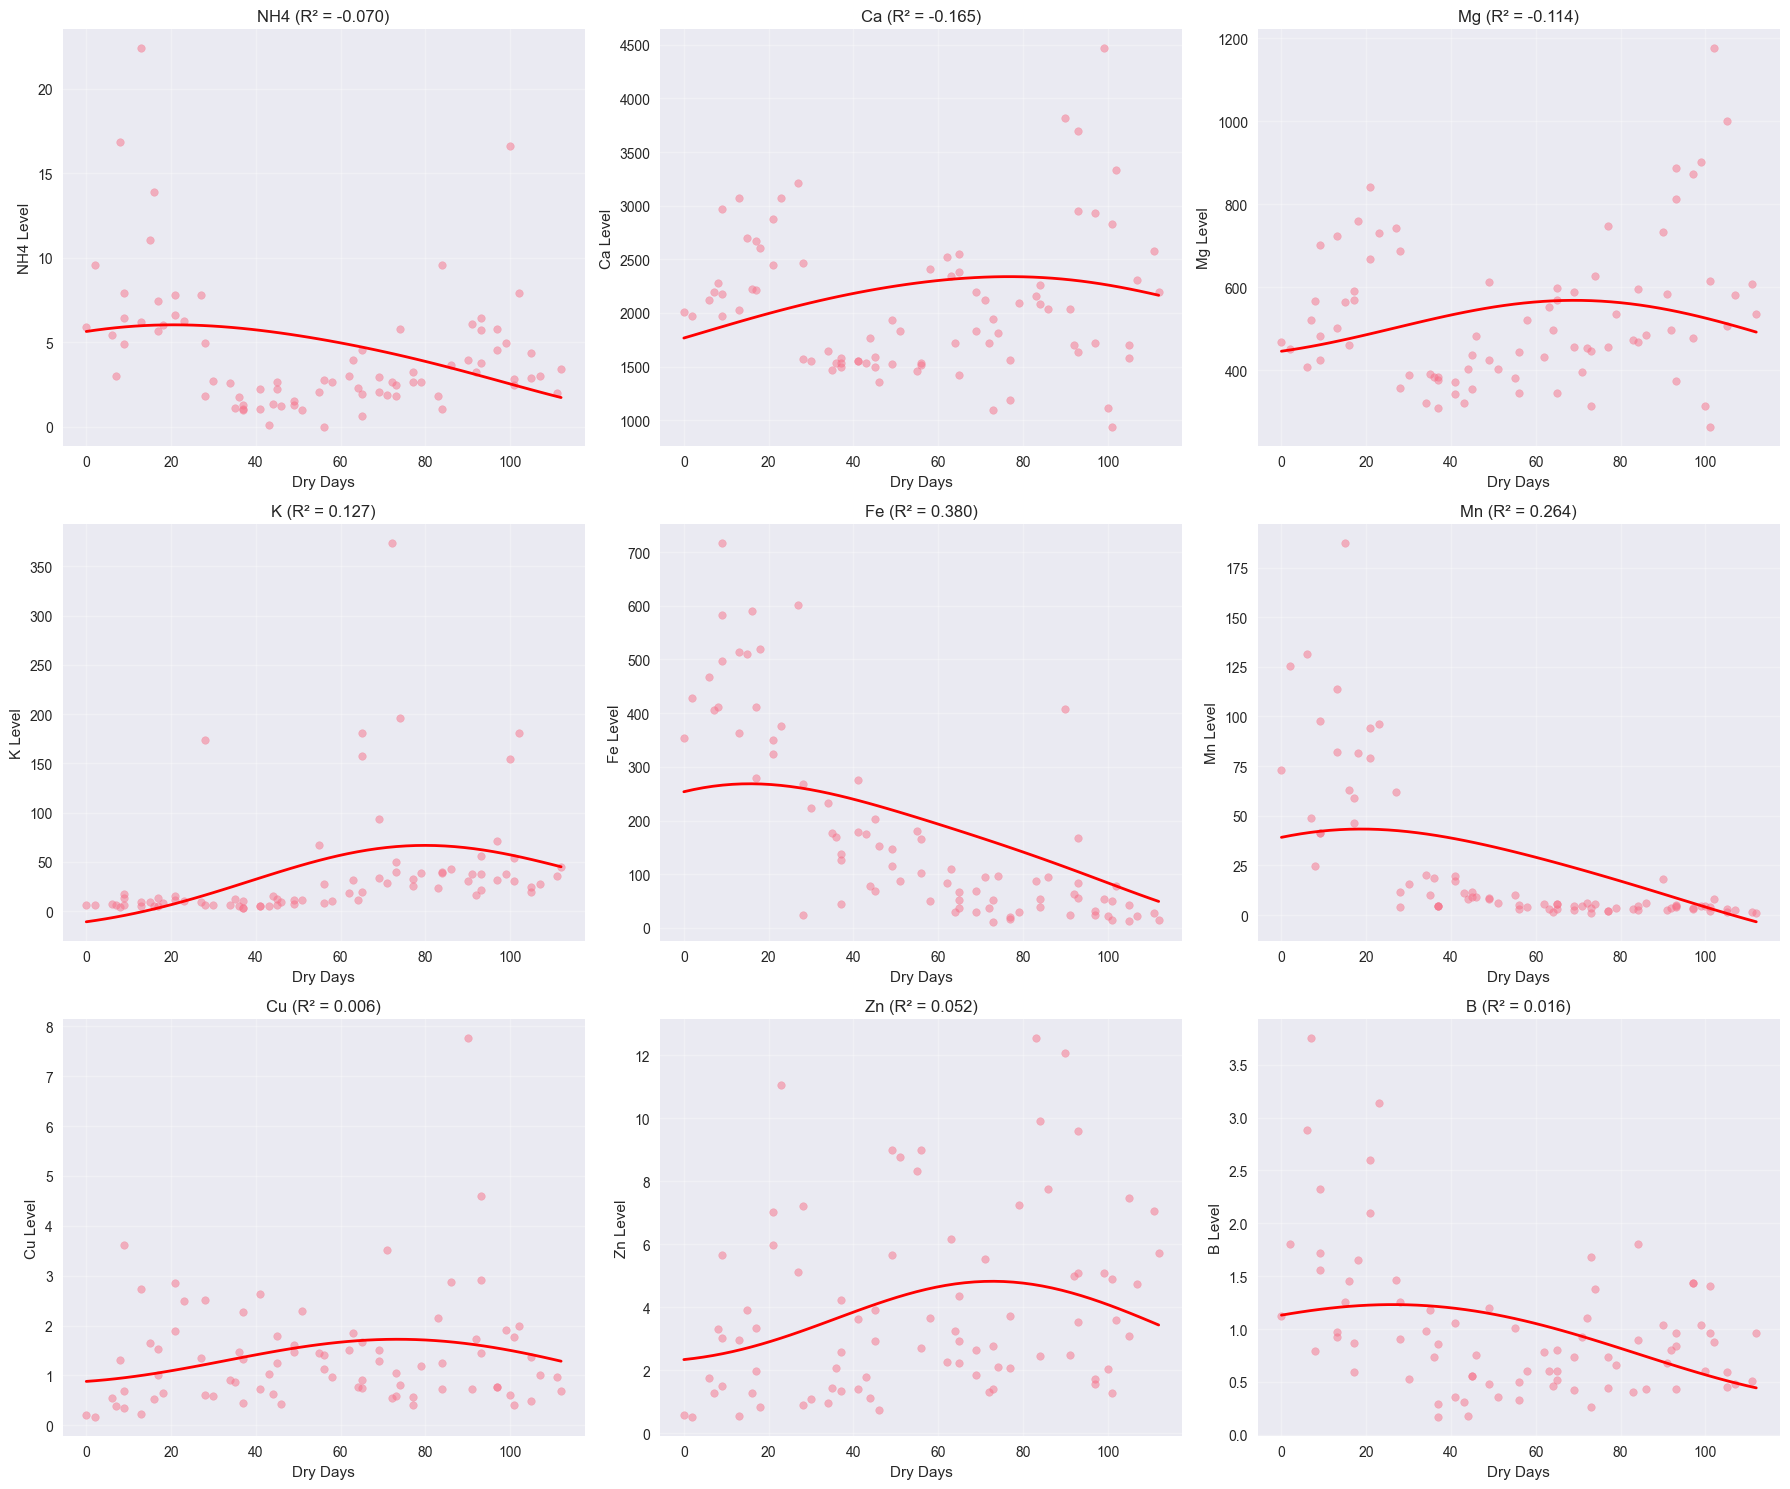

✅ Batch analysis complete!
🔄 Progress: 12/12 nutrients analyzed

📊 SUMMARY OF ALL NUTRIENTS:
TN   | R²:  0.077 | Corr:  0.248 | Weak
NO3  | R²:  0.078 | Corr:  0.269 | Weak
P    | R²:  0.374 | Corr: -0.655 | Moderate
NH4  | R²: -0.070 | Corr: -0.256 | Weak
Ca   | R²: -0.165 | Corr:  0.032 | Weak
Mg   | R²: -0.114 | Corr:  0.201 | Weak
K    | R²:  0.127 | Corr:  0.327 | Moderate
Fe   | R²:  0.380 | Corr: -0.777 | Strong
Mn   | R²:  0.264 | Corr: -0.679 | Moderate
Cu   | R²:  0.006 | Corr:  0.126 | Weak
Zn   | R²:  0.052 | Corr:  0.283 | Weak
B    | R²:  0.016 | Corr: -0.402 | Moderate

🏆 Top 5 nutrients with strongest correlation to dry days:
1. Fe: -0.777
2. Mn: -0.679
3. P: -0.655
4. B: -0.402
5. K: 0.327


In [16]:
# Cell 6: Batch Analysis of Remaining Nutrients
print("🔬 Analyzing remaining nutrients vs Dry Days...")

# Remaining nutrients to analyze
remaining_nutrients = ['NH4', 'Ca', 'Mg', 'K', 'Fe', 'Mn', 'Cu', 'Zn', 'B']
print(f"📊 Analyzing {len(remaining_nutrients)} remaining nutrients...")

# Function to analyze single nutrient
def analyze_nutrient(nutrient_name):
    print(f"  🔄 Processing {nutrient_name}...")
    
    # Extract data
    X = df['Dry_Days'].values
    y = df[nutrient_name].values
    
    # Remove NaN values
    mask = ~(np.isnan(X) | np.isnan(y))
    X = X[mask]
    y = y[mask]
    
    # Create and train QNN
    qr_temp = QuantumRegressor(n_qubits=3, n_layers=2)
    costs = qr_temp.train(X, y, epochs=60, lr=0.01) 
    
    # Calculate metrics
    y_pred = qr_temp.predict(X)
    r2 = r2_score(y, y_pred)
    correlation = np.corrcoef(X, y)[0, 1]
    
    return {
        'r2_score': r2,
        'correlation': correlation,
        'X_range': (X.min(), X.max()),
        'y_range': (y.min(), y.max()),
        'n_samples': len(X),
        'qr_model': qr_temp
    }

# Analyze all remaining nutrients
for nutrient in remaining_nutrients:
    results[nutrient] = analyze_nutrient(nutrient)

# Create summary visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, nutrient in enumerate(remaining_nutrients):
    ax = axes[i]
    
    # Get data
    X = df['Dry_Days'].values
    y = df[nutrient].values
    mask = ~(np.isnan(X) | np.isnan(y))
    X = X[mask]
    y = y[mask]
    
    # Get predictions
    X_pred = np.linspace(X.min(), X.max(), 50)
    y_pred = results[nutrient]['qr_model'].predict(X_pred)
    
    # Plot
    ax.scatter(X, y, alpha=0.5, s=30)
    ax.plot(X_pred, y_pred, color='red', linewidth=2)
    ax.set_title(f'{nutrient} (R² = {results[nutrient]["r2_score"]:.3f})')
    ax.set_xlabel('Dry Days')
    ax.set_ylabel(f'{nutrient} Level')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Batch analysis complete!")
print(f"🔄 Progress: {len(results)}/{len(nutrients)} nutrients analyzed")

# Summary statistics
print("\n📊 SUMMARY OF ALL NUTRIENTS:")
print("="*50)
for nutrient, data in results.items():
    strength = 'Strong' if abs(data['correlation']) > 0.7 else 'Moderate' if abs(data['correlation']) > 0.3 else 'Weak'
    print(f"{nutrient:4} | R²: {data['r2_score']:6.3f} | Corr: {data['correlation']:6.3f} | {strength}")

# Identify best correlations
best_nutrients = sorted(results.keys(), key=lambda x: abs(results[x]['correlation']), reverse=True)
print(f"\n🏆 Top 5 nutrients with strongest correlation to dry days:")
for i, nutrient in enumerate(best_nutrients[:5]):
    print(f"{i+1}. {nutrient}: {results[nutrient]['correlation']:.3f}")